In [1]:
# import time libraries
import time
from datetime import datetime
from time import gmtime, strftime

# Set Begin Time to Measure Time to Run of Whole Notebook
begin_time = time.time()

## Import Libraries and Set Options

In [2]:
# Standard Libraries

import pandas as pd
import numpy as np
import os
import math
import requests
from io import StringIO
import sys
import os.path
from IPython.display import display, HTML

# For Model Training
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import xgboost as feature_names

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

# For Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Building Histograms
from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as st
import scipy.stats
from scipy import stats

bold = "\033[1m"
reset = "\033[0;0m"

### Create Functions

In [3]:
### Create a Function to Build Histograms

def histogram(variable, name, color, bins):
    
    totalVals = variable.count
    missings = variable.isnull().sum(axis = 0).sum()
    variable2 = variable.dropna()
   
    # best fit of data
    (mu, sigma) = norm.fit(variable2)

    # the histogram of the data
    n, bins, patches = plt.hist(variable2, bins, density = True, facecolor = color, alpha = 0.75)
    
    # add a 'best fit' line
    y = scipy.stats.norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth = 2)

    #plot
    plt.xlabel(name + ': Missings = ' + str(missings))
    plt.ylabel('Probability')
    plt.title(r'$\mathrm{Histogram\ of\ ' + name + ':}\ \mu =%.3f,\ \sigma =%.3f$' %(mu, sigma))
    plt.grid(True)

    plt.show()

In [4]:
# Load DataFrames

os.chdir(sys.path[0] + '\\Data')

df_all = pd.read_pickle('df_all_2.pkl')

df_categorical = pd.read_pickle('df_categorical_2.pkl')
df_continuous = pd.read_pickle('df_continuous_2.pkl')

ColumnList = df_all.columns.tolist()

display(HTML(df_all[0:5].to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning_Other,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Other,LotShape_IR1,LotShape_Other,LotShape_Reg,LandContour_Lvl,LandContour_Other,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Other,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_Other,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Other,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,ExterCond_Gd,ExterCond_Other,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Other,BsmtQual_TA,BsmtCond_Other,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Other,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Other,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Other,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Other,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_Other,KitchenQual_TA,Functional_Other,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Other,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Other,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Other,GarageQual_TA,GarageCond_None,GarageCond_Other,GarageCond_TA,PavedDrive_N,PavedDrive_Other,PavedDrive_Y,Fence_MnPrv,Fence_None,Fence_Other,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,MSSubClass_band_gt_80,MSSubClass_band_lt_20,MSSubClass_band_lt_50,MSSubClass_band_lt_80,MoSold_band_Q1,MoSold_band_Q2,MoSold_band_Q3,MoSold_band_Q4
1459,1,train,65,19.212182,7,5,8.059126,11,0,150,11,11.692623,854,0.0,13.698888,1,0,2,1,3,0.730463,8,0,2,548.0,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,208500,7.0,7.0,7,2.0,14.976591,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0
1460,2,train,80,19.712205,6,8,0.000000,12,0,284,12,12.792276,0,0.0,12.792276,0,0,2,0,3,0.730463,6,1,2,460.0,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,181500,34.0,34.0,34,3.0,14.923100,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1461,3,train,68,20.347241,7,5,7.646538,10,0,434,11,11.892039,866,0.0,13.832085,1,0,2,1,3,0.730463,6,1,2,608.0,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,223500,9.0,8.0,9,2.0,15.149678,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1

In [5]:
RemoveList = ['Id','segment','SalePrice']

for i in range(0, len(RemoveList)):
    ColumnList.remove(RemoveList[i])

print(bold + 'Column List \n' + reset, ColumnList, '\n')

for i in range(0,len(ColumnList)):
    if df_all[ColumnList[i]].dtype == 'object':
        df_all[ColumnList[i]] = df_all[ColumnList[i]]
    elif df_all[ColumnList[i]].dtype == 'float32':
        df_all[ColumnList[i]] = int(df_all[ColumnList[i]])
    elif df_all[ColumnList[i]].dtype == 'float64':
        df_all[ColumnList[i]] = df_all[ColumnList[i]].fillna(0).astype(np.int32)
    elif df_all[ColumnList[i]].dtype == 'int64':
        df_all[ColumnList[i]] = df_all[ColumnList[i]].fillna(0).astype(np.int32)
    elif df_all[ColumnList[i]].dtype == 'uint8':
        df_all[ColumnList[i]] = df_all[ColumnList[i]].fillna(0).astype(np.int32)
    else:
        df_all[ColumnList[i]] = df_all[ColumnList[i]]
        
df_all.info()

Column List 
 ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'TotalSF', 'MSZoning_Other', 'MSZoning_RL', 'MSZoning_RM', 'Alley_None', 'Alley_Other', 'LotShape_IR1', 'LotShape_Other', 'LotShape_Reg', 'LandContour_Lvl', 'LandContour_Other', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_Inside', 'LotConfig_Other', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NridgHt', 'Neighborhood_O

In [6]:
df_train = df_all[df_all['segment'] == 'train']
df_test = df_all[df_all['segment'] == 'test']

# Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

display(HTML(df_train[0:5].to_html()))
display(HTML(df_train.tail().to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning_Other,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Other,LotShape_IR1,LotShape_Other,LotShape_Reg,LandContour_Lvl,LandContour_Other,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Other,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_Other,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Other,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,ExterCond_Gd,ExterCond_Other,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Other,BsmtQual_TA,BsmtCond_Other,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Other,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Other,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Other,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Other,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_Other,KitchenQual_TA,Functional_Other,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Other,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Other,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Other,GarageQual_TA,GarageCond_None,GarageCond_Other,GarageCond_TA,PavedDrive_N,PavedDrive_Other,PavedDrive_Y,Fence_MnPrv,Fence_None,Fence_Other,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,MSSubClass_band_gt_80,MSSubClass_band_lt_20,MSSubClass_band_lt_50,MSSubClass_band_lt_80,MoSold_band_Q1,MoSold_band_Q2,MoSold_band_Q3,MoSold_band_Q4
1459,1,train,65,19,7,5,8,11,0,150,11,11,854,0,13,1,0,2,1,3,0,8,0,2,548,0,5,0,0,0,0,0,208500,7,7,7,2,14,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0
1460,2,train,80,19,6,8,0,12,0,284,12,12,0,0,12,0,0,2,0,3,0,6,1,2,460,9,0,0,0,0,0,0,181500,34,34,34,3,14,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1461,3,train,68,20,7,5,7,10,0,434,11,11,866,0,13,1,0,2,1,3,0,6,1,2,608,0,5,0,0,0,0,0,223500,9,8,9,2,15,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0
1462,4,train,60,19,7,5,0,8,0,540

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning_Other,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Other,LotShape_IR1,LotShape_Other,LotShape_Reg,LandContour_Lvl,LandContour_Other,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Other,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_Other,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Other,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,ExterCond_Gd,ExterCond_Other,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Other,BsmtQual_TA,BsmtCond_Other,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Other,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Other,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Other,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Other,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_Other,KitchenQual_TA,Functional_Other,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Other,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Other,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Other,GarageQual_TA,GarageCond_None,GarageCond_Other,GarageCond_TA,PavedDrive_N,PavedDrive_Other,PavedDrive_Y,Fence_MnPrv,Fence_None,Fence_Other,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,MSSubClass_band_gt_80,MSSubClass_band_lt_20,MSSubClass_band_lt_50,MSSubClass_band_lt_80,MoSold_band_Q1,MoSold_band_Q2,MoSold_band_Q3,MoSold_band_Q4
2914,1456,train,62,18,6,5,0,0,0,953,11,11,694,0,13,0,0,2,1,3,0,7,1,2,460,0,4,0,0,0,0,0,175000,11,10,11,3,15,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0
2915,1457,train,85,20,6,6,7,11,7,589,13,14,0,0,14,1,0,2,0,3,0,7,2,2,500,9,0,0,0,0,0,0,210000,32,22,32,0,16,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
2916,1458,train,66,19,7,9,0,8,0,877,12,12,1152,0,14,0,0,2,0,4,0,9,2,1,252,0,5,0,0,0,0,14,266500,69,4,69,0,16,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
2917,1459,train,68

In [7]:
y = df_train['SalePrice'].values.astype(int)
X = df_train[ColumnList].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X

array([[65, 19,  7, ...,  0,  0,  0],
       [80, 19,  6, ...,  1,  0,  0],
       [68, 20,  7, ...,  0,  1,  0],
       ...,
       [66, 19,  7, ...,  1,  0,  0],
       [68, 19,  5, ...,  1,  0,  0],
       [75, 19,  5, ...,  1,  0,  0]])

In [8]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = ColumnList, missing = -99)
dtest = xgb.DMatrix(X_test, label = y_test, feature_names = ColumnList, missing = -99)

In [9]:
# Build the Baseline Model

# "Learn" the mean from the training data
mean_train = np.mean(y_train)

# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train

# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)

print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 56570.63


In [10]:
# Define Default Parameters

params = {
    
# Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'n_estimators':1000,
    'missing':-99,
    
# Other parameters
    'objective':'reg:linear',
    'silent': True
}

params['eval_metric'] = "mae"

# We still need to pass a num_boost_round which corresponds to the maximum number of boosting rounds that we allow.
# We set it to a large value hoping to find the optimal number of rounds before reaching it,
# if we haven't improved performance on our test dataset in early_stopping_round rounds

boosting_rounds = 999
stop_rounds = 20

In [11]:
%%time

# Here we will use our dtest DMatrix.
# early_stopping_rounds: The number of rounds without improvements after which we should stop, here we set it to 10.

model = xgb.train(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds = stop_rounds
)

print("Best MAE: {:.2f} with {} rounds".format(model.best_score,model.best_iteration+1))

[0]	Test-mae:126241
Will train until Test-mae hasn't improved in 20 rounds.
[1]	Test-mae:89110.8
[2]	Test-mae:63279.9
[3]	Test-mae:46275.3
[4]	Test-mae:34591.3
[5]	Test-mae:27404.7
[6]	Test-mae:23162.2
[7]	Test-mae:20841.6
[8]	Test-mae:19883.3
[9]	Test-mae:19316
[10]	Test-mae:19061.5
[11]	Test-mae:18895.3
[12]	Test-mae:18726.9
[13]	Test-mae:18555.9
[14]	Test-mae:18537.1
[15]	Test-mae:18372.8
[16]	Test-mae:18514.1
[17]	Test-mae:18476
[18]	Test-mae:18515.5
[19]	Test-mae:18484.9
[20]	Test-mae:18504.2
[21]	Test-mae:18502.7
[22]	Test-mae:18425
[23]	Test-mae:18404.3
[24]	Test-mae:18342.2
[25]	Test-mae:18387.9
[26]	Test-mae:18396.2
[27]	Test-mae:18393.2
[28]	Test-mae:18342.8
[29]	Test-mae:18339.1
[30]	Test-mae:18380.8
[31]	Test-mae:18364.4
[32]	Test-mae:18334.1
[33]	Test-mae:18353.1
[34]	Test-mae:18394
[35]	Test-mae:18420
[36]	Test-mae:18395.1
[37]	Test-mae:18422.9
[38]	Test-mae:18412.9
[39]	Test-mae:18425.8
[40]	Test-mae:18418.1
[41]	Test-mae:18421
[42]	Test-mae:18400.9
[43]	Test-mae:18408.1

In [12]:
%%time

# Let's see what cross-validation score we get with our current parameters:

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    seed = 42,
    nfold = 5,
    metrics = {'mae'},
    early_stopping_rounds = stop_rounds
)

display(HTML(cv_results.head(n=5).to_html()))
display(HTML(cv_results.tail(n=5).to_html()))
print(cv_results['test-mae-mean'].min())

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,128208.775000,1151.120802,128643.756250,4764.826229
1,90706.056250,826.777295,91288.885938,3739.772316
2,64313.123438,564.613520,65663.473437,3120.026686
3,45750.406250,382.936470,48194.999219,2479.369052
4,32797.310547,296.453945,36639.889062,2198.211502


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
85,650.844848,75.458449,18608.640430,2202.547193
86,632.740296,77.911015,18606.996484,2199.988620
87,601.369708,71.407729,18601.698633,2194.218675
88,578.547577,66.191065,18601.495899,2197.316064
89,562.935968,65.943419,18601.131641,2197.918746


18601.1316406
Wall time: 1.19 s


In [13]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

for eta in [.2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

# We update our parameters
    params['eta'] = eta

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['eta'] = best_params
print(params['eta'])

CV with eta=0.2
	MAE 18348.225195400002 for 56 rounds

CV with eta=0.1
	MAE 17627.6273438 for 147 rounds

CV with eta=0.05
	MAE 17670.301172 for 287 rounds

CV with eta=0.01
	MAE 17630.0265624 for 998 rounds

CV with eta=0.005
	MAE 18056.1314452 for 998 rounds

Best params: 0.1, MAE: 17627.6273438
0.1
Wall time: 26.8 s


In [14]:
# You can try wider intervals with a larger step between each value and then narrow it down.
# Here after several iteration I found that the optimal value was in the following ranges.

# range(9,12) --> [int(x) for x in np.linspace(start = 4, stop = 20, num = 8)]
# range(5,8) --> [int(x) for x in np.linspace(start = 2, stop = 10, num = 8)]

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in [int(x) for x in np.linspace(start = 4, stop = 20, num = 4)]
    for min_child_weight in [int(x) for x in np.linspace(start = 4, stop = 16, num = 4)]
]

In [15]:
%%time

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth,min_child_weight))

# Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

# Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = boosting_rounds,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds = stop_rounds
    )

# Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

print(params['max_depth'])
print(params['min_child_weight'])

CV with max_depth=4, min_child_weight=4
	MAE 17113.322461 for 248 rounds
CV with max_depth=4, min_child_weight=8
	MAE 17967.830469 for 207 rounds
CV with max_depth=4, min_child_weight=12
	MAE 18435.8830078 for 62 rounds
CV with max_depth=4, min_child_weight=16
	MAE 18111.1359376 for 101 rounds
CV with max_depth=9, min_child_weight=4
	MAE 17982.0498048 for 127 rounds
CV with max_depth=9, min_child_weight=8
	MAE 17923.2052732 for 96 rounds
CV with max_depth=9, min_child_weight=12
	MAE 18129.666796600002 for 53 rounds
CV with max_depth=9, min_child_weight=16
	MAE 18017.9527346 for 67 rounds
CV with max_depth=14, min_child_weight=4
	MAE 18028.8923828 for 170 rounds
CV with max_depth=14, min_child_weight=8
	MAE 17813.111133 for 96 rounds
CV with max_depth=14, min_child_weight=12
	MAE 18115.1199218 for 48 rounds
CV with max_depth=14, min_child_weight=16
	MAE 18158.1509764 for 69 rounds
CV with max_depth=20, min_child_weight=4
	MAE 18116.7292968 for 123 rounds
CV with max_depth=20, min_child_

In [16]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(6,11)]
]

In [17]:
%%time

min_mae = float("Inf")
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(subsample,colsample))

# We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

# Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = boosting_rounds,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds = stop_rounds
    )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

print(params['subsample'])
print(params['colsample_bytree'])

CV with subsample=1.0, colsample=1.0
	MAE 17113.322461 for 248 rounds
CV with subsample=1.0, colsample=0.9
	MAE 17253.3031252 for 206 rounds
CV with subsample=1.0, colsample=0.8
	MAE 17234.7050782 for 211 rounds
CV with subsample=1.0, colsample=0.7
	MAE 17117.867187800002 for 145 rounds
CV with subsample=1.0, colsample=0.6
	MAE 17210.310742 for 167 rounds
CV with subsample=0.9, colsample=1.0
	MAE 17183.114843800002 for 277 rounds
CV with subsample=0.9, colsample=0.9
	MAE 17018.470703400002 for 184 rounds
CV with subsample=0.9, colsample=0.8
	MAE 17033.2607422 for 221 rounds
CV with subsample=0.9, colsample=0.7
	MAE 16845.3515624 for 239 rounds
CV with subsample=0.9, colsample=0.6
	MAE 16896.4433594 for 152 rounds
CV with subsample=0.8, colsample=1.0
	MAE 17356.8214844 for 161 rounds
CV with subsample=0.8, colsample=0.9
	MAE 17121.866015400003 for 220 rounds
CV with subsample=0.8, colsample=0.8
	MAE 17417.9869142 for 112 rounds
CV with subsample=0.8, colsample=0.7
	MAE 16931.9285156 for

In [18]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

# for gamma in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
for gamma in [0.00, 0.050, 0.50, 1.00, 5.00, 10.00]:
    print("CV with gamma={}".format(gamma))

# We update our parameters
    params['gamma'] = gamma

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = gamma

print("Best params: {}, MAE: {}".format(best_params, min_mae))


params['gamma'] = best_params
# params['gamma'] = 0

print(params['gamma'])

CV with gamma=0.0
	MAE 16845.3515624 for 239 rounds

CV with gamma=0.05
	MAE 16845.3515624 for 239 rounds

CV with gamma=0.5
	MAE 16845.3515624 for 239 rounds

CV with gamma=1.0
	MAE 16845.3515624 for 239 rounds

CV with gamma=5.0
	MAE 16845.3515624 for 239 rounds

CV with gamma=10.0
	MAE 16845.3515624 for 239 rounds

Best params: 0.0, MAE: 16845.3515624
0.0
Wall time: 9.7 s


In [19]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

for alpha in [1e-5, 1e-2, 0.1, 1, 100]:
    print("CV with alpha={}".format(alpha))

# We update our parameters
    params['reg_alpha'] = alpha

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = alpha

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['reg_alpha'] = best_params

print(params['reg_alpha'])

CV with alpha=1e-05
	MAE 16845.351757599998 for 239 rounds

CV with alpha=0.01
	MAE 16845.351952999998 for 239 rounds

CV with alpha=0.1
	MAE 16845.350586 for 239 rounds

CV with alpha=1
	MAE 16845.3484376 for 239 rounds

CV with alpha=100
	MAE 16905.263085799997 for 136 rounds

Best params: 1, MAE: 16845.3484376
1
Wall time: 7.44 s


In [20]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

for lambdaVal in [1e-5, 1e-2, 0.1, 1, 10, 100]:
    print("CV with lambda = {}".format(lambdaVal))

# We update our parameters
    params['reg_lambda'] = lambdaVal

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = lambdaVal

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['reg_lambda'] = best_params

print(params['reg_lambda'])

CV with lambda = 1e-05
	MAE 17099.4937498 for 154 rounds

CV with lambda = 0.01
	MAE 17032.3771484 for 242 rounds

CV with lambda = 0.1
	MAE 17388.8582032 for 117 rounds

CV with lambda = 1
	MAE 16845.3484376 for 239 rounds

CV with lambda = 10
	MAE 16771.6667968 for 304 rounds

CV with lambda = 100
	MAE 18085.066211 for 390 rounds

Best params: 10, MAE: 16771.6667968
10
Wall time: 9.55 s


In [21]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

for booster in ['gbtree', 'gblinear']:
    print("CV with booster={}".format(booster))

# We update our parameters
    params['booster'] = booster

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = booster

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['booster'] = best_params

print(params['booster'])

CV with booster=gbtree
	MAE 16771.6667968 for 304 rounds

CV with booster=gblinear
	MAE 29413.6804686 for 52 rounds

Best params: gbtree, MAE: 16771.6667968
gbtree
Wall time: 2.16 s


In [22]:
# Final Dictionary
params

{'max_depth': 4,
 'min_child_weight': 4,
 'eta': 0.1,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'n_estimators': 1000,
 'missing': -99,
 'objective': 'reg:linear',
 'silent': True,
 'eval_metric': 'mae',
 'gamma': 0.0,
 'reg_alpha': 1,
 'reg_lambda': 10,
 'booster': 'gbtree'}

In [23]:
# Let's train a model with it and see how well it does on our test set!

model = xgb.train(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds = 10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:162097
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:146610
[2]	Test-mae:132499
[3]	Test-mae:120027
[4]	Test-mae:108687
[5]	Test-mae:98331.2
[6]	Test-mae:89041.9
[7]	Test-mae:80528.5
[8]	Test-mae:73120.4
[9]	Test-mae:66340.7
[10]	Test-mae:60225.7
[11]	Test-mae:54921.4
[12]	Test-mae:50140.5
[13]	Test-mae:45847.5
[14]	Test-mae:41970.1
[15]	Test-mae:38503.6
[16]	Test-mae:35514.5
[17]	Test-mae:32846.1
[18]	Test-mae:30489.2
[19]	Test-mae:28535.3
[20]	Test-mae:26764.6
[21]	Test-mae:25285.9
[22]	Test-mae:24060.2
[23]	Test-mae:23027.1
[24]	Test-mae:22182.7
[25]	Test-mae:21372.2
[26]	Test-mae:20727.3
[27]	Test-mae:20186.7
[28]	Test-mae:19607.7
[29]	Test-mae:19155.5
[30]	Test-mae:18842.2
[31]	Test-mae:18598.4
[32]	Test-mae:18365.9
[33]	Test-mae:18178.1
[34]	Test-mae:18035.2
[35]	Test-mae:17903.4
[36]	Test-mae:17735.6
[37]	Test-mae:17610.3
[38]	Test-mae:17480.2
[39]	Test-mae:17333.4
[40]	Test-mae:17274.8
[41]	Test-mae:17176
[42]	Test-mae:17098.6
[43]	Test-mae:1

In [24]:
# Let's train a model with it and see how well it does on our test set!

num_boost_round = model.best_iteration + 1

best_model = xgb.train(
    params,
    dtrain,
    #num_boost_round = boosting_rounds,
    num_boost_round = num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:162097
[1]	Test-mae:146610
[2]	Test-mae:132499
[3]	Test-mae:120027
[4]	Test-mae:108687
[5]	Test-mae:98331.2
[6]	Test-mae:89041.9
[7]	Test-mae:80528.5
[8]	Test-mae:73120.4
[9]	Test-mae:66340.7
[10]	Test-mae:60225.7
[11]	Test-mae:54921.4
[12]	Test-mae:50140.5
[13]	Test-mae:45847.5
[14]	Test-mae:41970.1
[15]	Test-mae:38503.6
[16]	Test-mae:35514.5
[17]	Test-mae:32846.1
[18]	Test-mae:30489.2
[19]	Test-mae:28535.3
[20]	Test-mae:26764.6
[21]	Test-mae:25285.9
[22]	Test-mae:24060.2
[23]	Test-mae:23027.1
[24]	Test-mae:22182.7
[25]	Test-mae:21372.2
[26]	Test-mae:20727.3
[27]	Test-mae:20186.7
[28]	Test-mae:19607.7
[29]	Test-mae:19155.5
[30]	Test-mae:18842.2
[31]	Test-mae:18598.4
[32]	Test-mae:18365.9
[33]	Test-mae:18178.1
[34]	Test-mae:18035.2
[35]	Test-mae:17903.4
[36]	Test-mae:17735.6
[37]	Test-mae:17610.3
[38]	Test-mae:17480.2
[39]	Test-mae:17333.4
[40]	Test-mae:17274.8
[41]	Test-mae:17176
[42]	Test-mae:17098.6
[43]	Test-mae:17006.9
[44]	Test-mae:16961.3
[45]	Test-mae:16863.6
[46]	

In [25]:
mean_absolute_error(best_model.predict(dtest), y_test)

14916.813275898972

In [26]:
%%time

# Let's see what cross-validation score we get with our current parameters:

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    #num_boost_round = 500,
    seed = 42,
    nfold = 5,
    metrics = {'mae'},
    early_stopping_rounds = stop_rounds
)

Wall time: 1.93 s


In [27]:
print(cv_results.head(n=5))
print(cv_results.tail(n=5))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   164379.140625    1558.783608  164477.725000   5902.096693
1   148760.634375    1460.447038  148911.981250   5639.762881
2   134682.340625    1312.142788  134673.410938   5521.062178
3   121973.803125    1241.871847  121907.898438   5222.565498
4   110545.396875    1146.059278  110527.001563   4979.990848
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
300     5409.262012     226.809243   16784.151563   1654.656522
301     5392.618164     232.347093   16785.087695   1653.032651
302     5368.948145     223.919600   16778.403711   1658.773172
303     5348.324121     223.109416   16771.927734   1654.695551
304     5331.743750     224.172499   16771.666797   1664.120029


In [28]:
%%time

# Let's see what cross-validation score we get with our current parameters:

cv_results2 = xgb.cv(
    params,
    dtrain,
    #num_boost_round = boosting_rounds,
    num_boost_round = 500,
    seed = 42,
    nfold = 5,
    metrics = {'mae'}
    #early_stopping_rounds = stop_rounds
)

Wall time: 3.02 s


In [29]:
print(cv_results2.head(n=5))
print(cv_results2.tail(n=5))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   164379.140625    1558.783608  164477.725000   5902.096693
1   148760.634375    1460.447038  148911.981250   5639.762881
2   134682.340625    1312.142788  134673.410938   5521.062178
3   121973.803125    1241.871847  121907.898438   5222.565498
4   110545.396875    1146.059278  110527.001563   4979.990848
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
495     3007.480225     172.540134   16887.371484   1663.804261
496     2997.823682     171.068364   16890.960156   1658.852019
497     2990.379981     173.552440   16891.322266   1660.870827
498     2982.548584     175.157616   16890.491797   1661.454367
499     2973.696143     173.354447   16891.260937   1661.826187


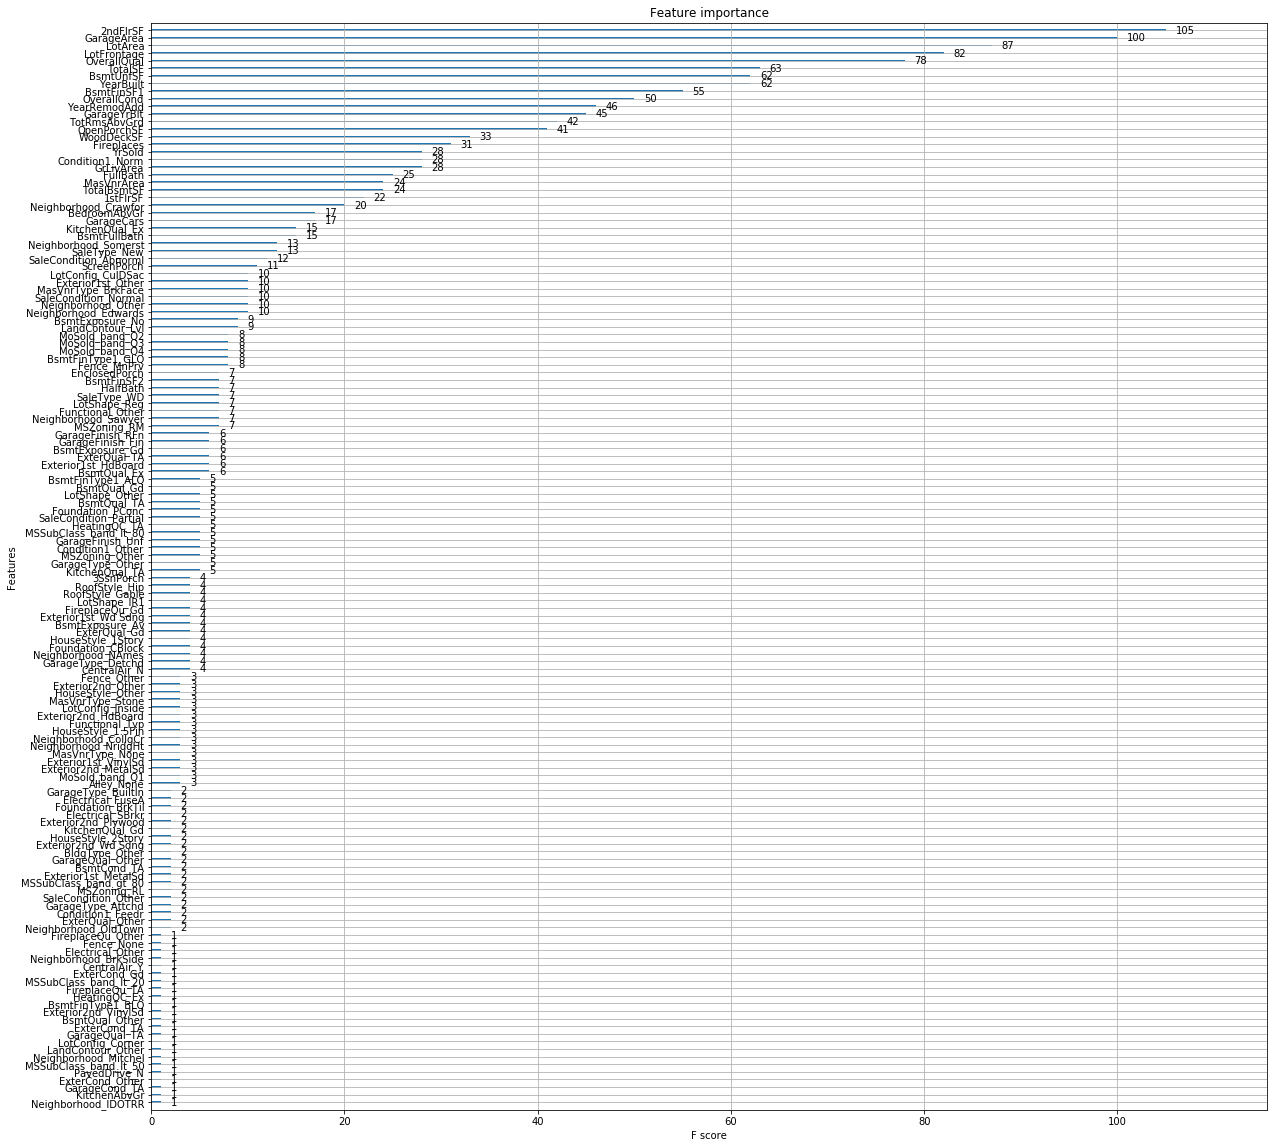

In [30]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
xgb.plot_importance(model, ax=ax)

In [31]:
os.chdir(sys.path[0] + '\\Data')

best_model.save_model("Ames_XGB.model")

In [32]:
# Reload the Model

loaded_model = xgb.Booster()
loaded_model.load_model("Ames_XGB.model")

y = df_test['SalePrice'].values.astype(int)
X = df_test[ColumnList].values.astype(int)

dtest = xgb.DMatrix(X, label = y, feature_names = ColumnList, missing = -99)

# And use it for predictions.
y_test_pred = loaded_model.predict(dtest)

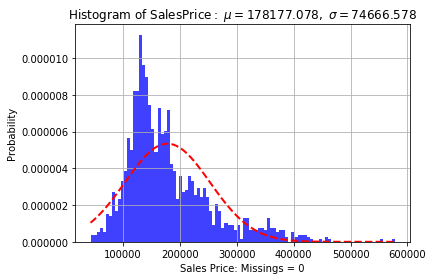

In [33]:
len(test_ID)
len(y_test_pred)

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_test_pred

histogram(sub['SalePrice'], 'Sales Price', 'blue', 100)

In [34]:
# sub['SalePrice'] = np.expm1(sub['SalePrice'])
# histogram(sub['SalePrice'], 'Sales Price', 'blue', 100)

In [35]:
sub.to_csv('submission.csv',index=False)

In [36]:
end_time = time.time()

diff = end_time - begin_time

print("run time ...", "\n")
print(diff, "seconds")
print(diff / 60, "minutes")
print(diff / 3600, "hours")

run time ... 

129.52369499206543 seconds
2.158728249867757 minutes
0.03597880416446262 hours
